To start this recipe, one must should first preprocess the traing.1600000.processed.noemoticon.csv file from the Kaggle data source. Once this file is downloaded, navigate to the directory in terminal and enter the following command:

    iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

## How to do it...

1. Import the required packages

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

2. Define model hyperparameters

In [2]:
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 160000
test_portion=0.1

num_epochs = 50
dropout_val = 0.2
nof_units=64

corpus = []

3. Encapsulate model creation step into a function

In [3]:
def create_model(dropout_val, nof_units):

    
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(dropout_val),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(nof_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

4. Collect content of the corpus to train on

In [4]:
num_sentences = 0

with open("training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

5. Convert to sentence format:

In [5]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

6. Tokenize the sentences

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(sentences)

7. Normalize the sentence lengths with padding

In [7]:
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

8. Divide into training and holdout sets

In [8]:
split = int(test_portion * training_size)
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

9. A key element in RNN-based models for NLP applications is the embeddings matrix

In [9]:
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
        
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

10. Setup model

In [10]:
model = create_model(dropout_val, nof_units)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13899200  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,964,353
Trainable params: 65,153
Non-trainable params: 13,899,200
_______________________________________

11. Train in the usual manner

11. a) Convert data to np arrays (else error occurs)

In [11]:
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

In [12]:
num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

Epoch 1/50
4500/4500 - 9s - loss: 0.5683 - accuracy: 0.6976 - val_loss: 0.5285 - val_accuracy: 0.7323
Epoch 2/50
4500/4500 - 7s - loss: 0.5287 - accuracy: 0.7309 - val_loss: 0.5087 - val_accuracy: 0.7433
Epoch 3/50
4500/4500 - 7s - loss: 0.5118 - accuracy: 0.7429 - val_loss: 0.5062 - val_accuracy: 0.7479
Epoch 4/50
4500/4500 - 7s - loss: 0.5005 - accuracy: 0.7499 - val_loss: 0.5048 - val_accuracy: 0.7502
Epoch 5/50
4500/4500 - 7s - loss: 0.4921 - accuracy: 0.7569 - val_loss: 0.4969 - val_accuracy: 0.7508
Epoch 6/50
4500/4500 - 6s - loss: 0.4857 - accuracy: 0.7603 - val_loss: 0.4983 - val_accuracy: 0.7517
Epoch 7/50
4500/4500 - 7s - loss: 0.4808 - accuracy: 0.7626 - val_loss: 0.4966 - val_accuracy: 0.7529
Epoch 8/50
4500/4500 - 7s - loss: 0.4743 - accuracy: 0.7684 - val_loss: 0.4997 - val_accuracy: 0.7553
Epoch 9/50
4500/4500 - 7s - loss: 0.4700 - accuracy: 0.7703 - val_loss: 0.4978 - val_accuracy: 0.7532
Epoch 10/50
4500/4500 - 7s - loss: 0.4673 - accuracy: 0.7712 - val_loss: 0.4990 - 

12. Plot results

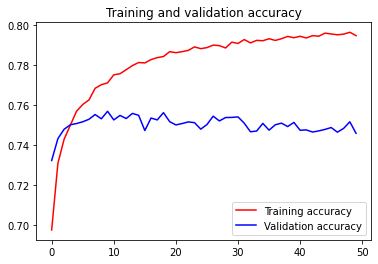

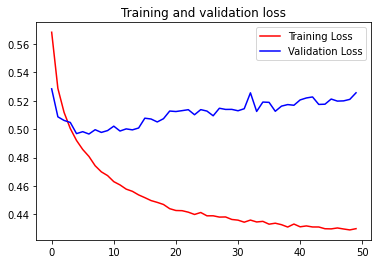

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()